# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
# read data
data = pd.read_csv("data/users_data.csv")

In [3]:
# display top 5 roles
data.head()

,user_id,loan_score,device_rating,data_quality,ltv_rate,bureau_score,total_tenure,months_active,savings_score,tx_score,usage_score,airtime_score,cluster
0,146245,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,NaN
1,248802,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,NaN
2,13873,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,NaN
3,35230,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,NaN
4,653322,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,NaN


In [4]:
# check data dimension
data.shape

(1599, 13)

# check for missing values

In [5]:
# check for missing values
data.isnull().sum()

user_id             0
loan_score          0
device_rating       0
data_quality        0
ltv_rate            0
bureau_score        0
total_tenure        0
months_active       0
savings_score       0
tx_score            0
usage_score         0
airtime_score       0
cluster          1599
dtype: int64

In [6]:
# check data descriptive statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1599.0,397669.085679,228348.459331,1449.00000,196569.5000,398366.00000,592184.000000,798882.00000
loan_score,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
device_rating,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
data_quality,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
ltv_rate,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
bureau_score,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
total_tenure,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
months_active,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
savings_score,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
tx_score,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000


# check for duplicates rows

In [7]:
# check for duplicates with userID
data["user_id"].nunique()

1599

no duplicates. number of uniqueID is same as total number of records.

# Drop redundant features:- User_ID, Cluster

In [8]:
# drop cluster column:
data = data.drop(["cluster","user_id"],axis =1)

# Explore data

**Check correlation of features**

In [9]:
# define a functiont to check for features correlation
def corr_plot(data_frame):
    # get correlation of dataframe
    df_corr = data_frame.corr(method = "spearman")
    # draw heatmap of correlation
    plt.figure(figsize = (10,8))
    mask_1 = np.triu(np.ones_like(data_frame.corr(), dtype = bool))
    sns.heatmap(data=df_corr, cmap = "viridis", vmin = -1, vmax = 1, mask = mask_1, annot = True)
    plt.xticks(rotation = 70)
    plt.show()

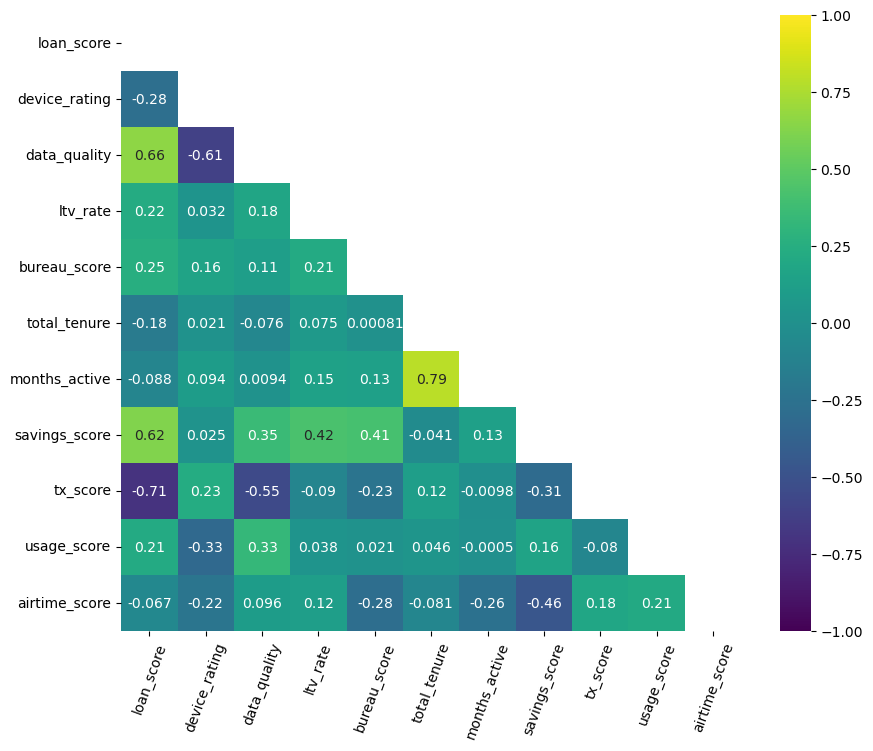

In [10]:
corr_plot(data)

**Check for features distribution**

In [11]:
# define a functiont to plot distribution of features
def create_hist_plot(data_frame, feature_list):
    num_features = len(feature_list)
    num_rows = (num_features + 1) // 2
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(10,8))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Iterate over each feature and create a boxplot
    for i, feature in enumerate(feature_list):
        ax = axes[i]
        sns.histplot(data_frame[feature], color='skyblue',ax=ax)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

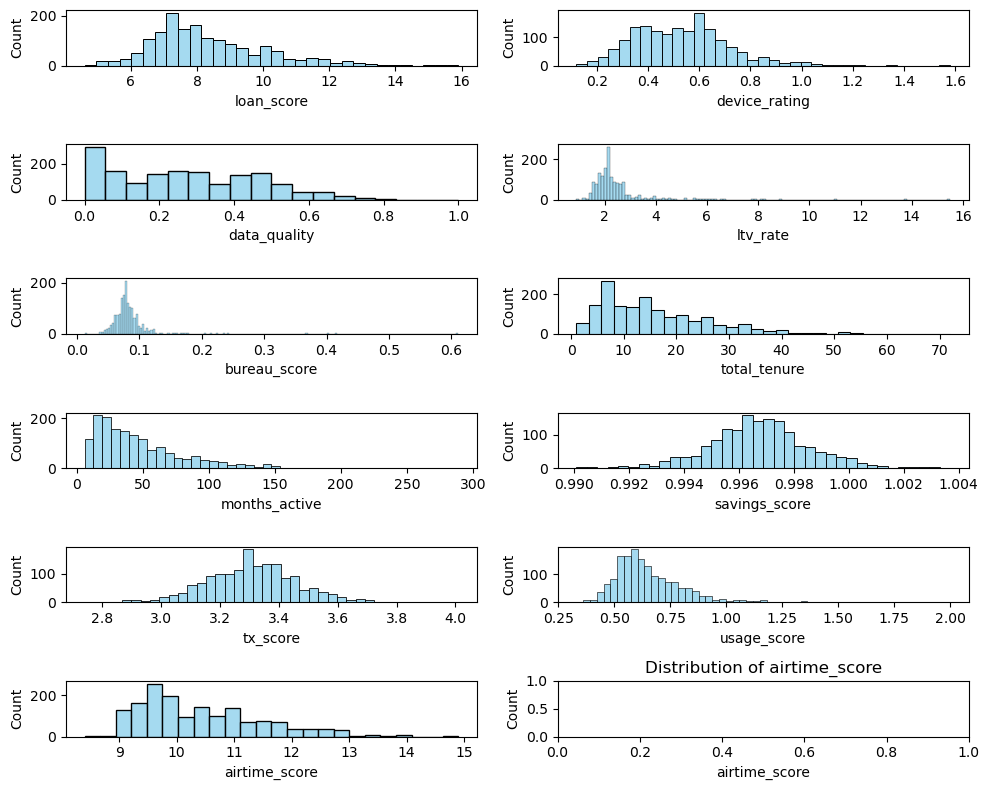

In [12]:
create_hist_plot(data_frame=data, feature_list=data.columns.to_list())

**Observation**
- **Correlation plot**
- From the heatmap, alot of features have significant correlation with themselves.
- High correlation between features (multicolinearity) can affect algorithm like k-means that assums features to be independent.
- PCA is a good way to remove multicolinearity while retaining overall explained variance.

- **Histogram**
- The dataset possess features with alot of outliers. Applying a clustering technique that is sensitive to outliers like K-means might not be a good choice.
- DBscan is more robust to outliers and is capable of filtering these outliers into a separate cluster 

## Address outliers

In [13]:
# define function to remove outlier
def remove_outliers(df, columns):
    for column_name in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        # Calculate the IQR
        IQR = Q3 - Q1

        # Define bounds for outliers
        upper_bound = Q3 + 1.5 * IQR

        #Define lower bound for outliers
        lower_bound = Q1 - 1.5*IQR

        # Cap values above the upper bound and lower bound 
        df[column_name] = df[column_name].apply(lambda x: min(x, upper_bound))
        df[column_name] = df[column_name].apply(lambda x: max(x,lower_bound))

    return df

In [14]:
# apply function to remove outlier
new_data = remove_outliers(df = data, columns=data.columns.to_list())

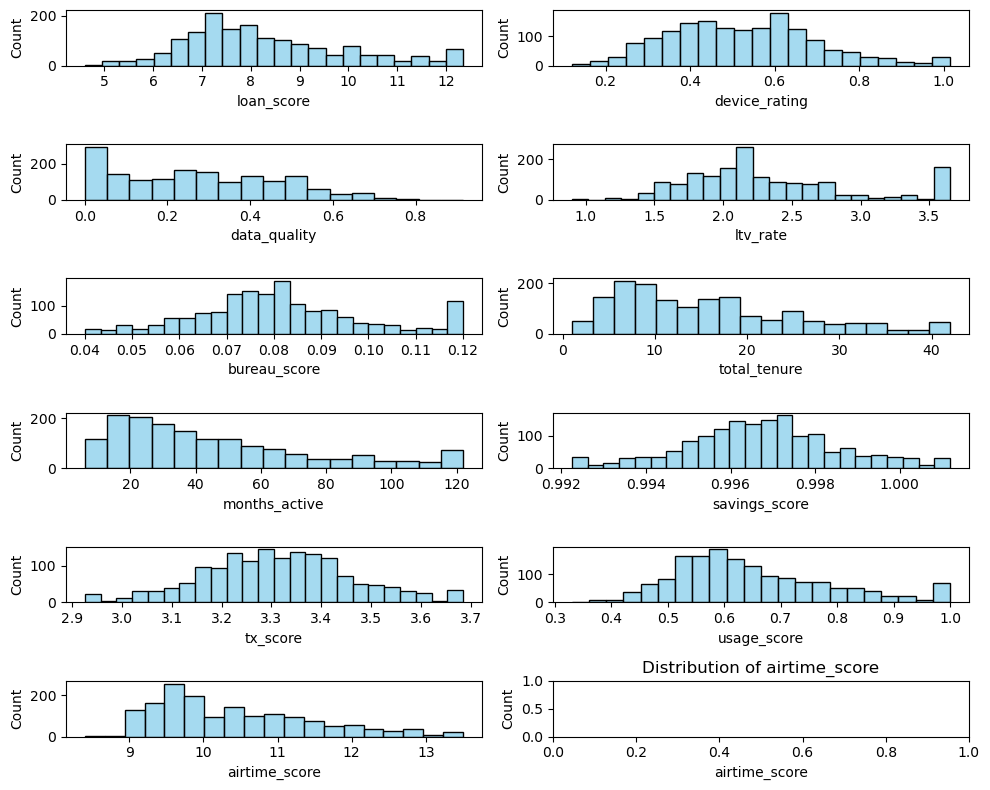

In [15]:
# check for any existing outlier
create_hist_plot(data_frame=new_data, feature_list=data.columns.to_list())

# Transform data

Since every feature on the data is numerical. Perform standard scaling to improve the result from clustering algorithm

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
# scale data
transformed_df = scaler.fit_transform(new_data)

In [18]:
transformed_df = pd.DataFrame(transformed_df, columns=new_data.columns.tolist())

In [19]:
transformed_df.head()

,loan_score,device_rating,data_quality,ltv_rate,bureau_score,total_tenure,months_active,savings_score,tx_score,usage_score,airtime_score
0,-0.538197,0.997591,-1.392540,-0.693182,-0.291550,-0.476813,-0.385806,0.585705,1.332717,-0.655496,-0.966950
1,-0.296555,2.032132,-1.392540,0.455672,0.943237,0.946759,0.700988,0.031853,-0.736650,0.220142,-0.587615
2,-0.296555,1.342438,-1.186940,-0.036694,0.606477,-0.070078,0.272857,0.142624,-0.336128,0.001232,-0.587615
3,1.757401,-1.416339,1.485857,-0.693182,-0.347676,0.133289,0.470456,0.696475,-1.003665,-0.509557,-0.587615
4,-0.538197,0.997591,-1.392540,-0.693182,-0.291550,-0.476813,-0.385806,0.585705,1.332717,-0.655496,-0.966950


# Create Clusters

## K-means

In [20]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [21]:
# create function to check for optimal number of clusters
def create_k_means(data_frame):
    num_cluster = range(1,9) # number of clusters to create
    inertia = []

    #create clusters from num_cluster and save inertia into the list
    for cluster in num_cluster:
        kmeans = KMeans(n_clusters= cluster, random_state = 5)
        kmeans.fit(data_frame)
        inertia.append(kmeans.inertia_)
        
    # plot elbow
    plt.figure(figsize = (6,6))
    plt.plot(num_cluster, inertia, marker = "o")
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

## Perform K-means on transformed data without outliers

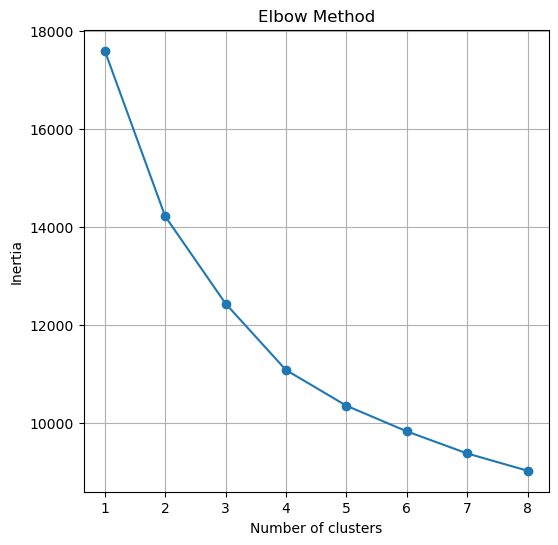

In [22]:
create_k_means(transformed_df)

**Observation**
- The elbow seems to be around 3 or 4 clusters but not very visible.

## perform K-means on data that is untransformed and with outlier

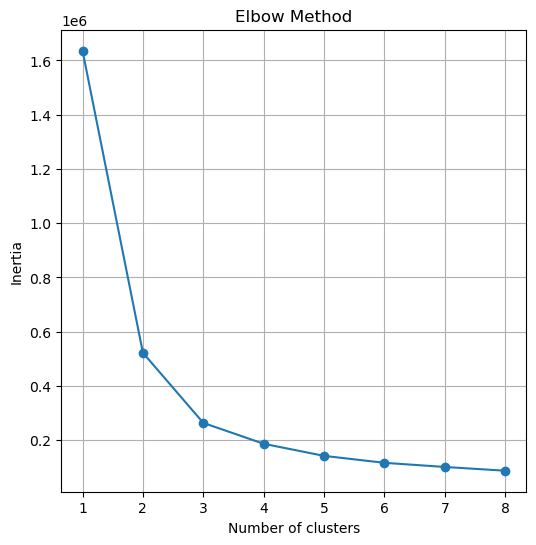

In [23]:
create_k_means(data)

**Observation**
- Clear elbow at 3 cluster. This indicates that increasing the number of clusters beyond this point does not result in significantly better modeling of the data.

## Create final cluster using without transforming or removing outliers from the dataset

Since the intstruction says **4 to 6 clusters** should be created. create 4 clusters. **Although from the elbow on the chart above, 3 seems to be the optimal number of clusters on this dataset**

In [24]:
# Create 4 clusters using k-means
kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust n_clusters based on your needs

# Fit K-Means on the data
kmeans.fit(data)

# Get cluster labels
clusters = kmeans.labels_

# Add clusters to DataFrame for analysis
data['Cluster'] = clusters


## Visualize clusters using PCA

<Axes: xlabel='0', ylabel='1'>

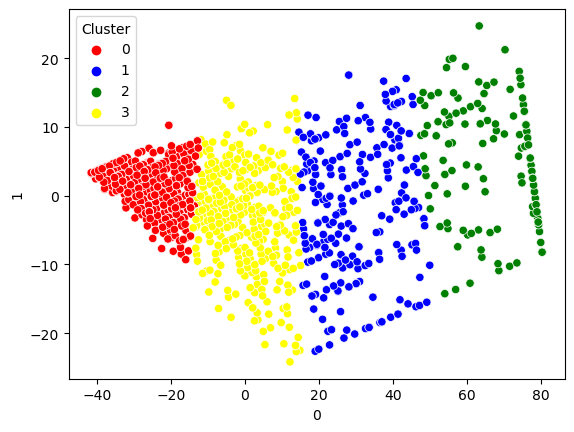

In [25]:
def create_cluster_plot(data_frame, cluster):
    df = data_frame.drop([cluster], axis = 1)

    #initialize pca
    pca = PCA(n_components=2, random_state=360)

    #fit pca
    pca_array = pca.fit_transform(df)
    pca_df = pd.DataFrame(data = pca_array)
    pca_df[cluster] = data_frame[cluster]  
    return pca_df


x = create_cluster_plot(data_frame=data, cluster="Cluster")
sns.scatterplot(x = x[0],y=x[1],hue=x["Cluster"],palette=["red", "blue", "green", "yellow"])

## Visualize cluster using T-SNE

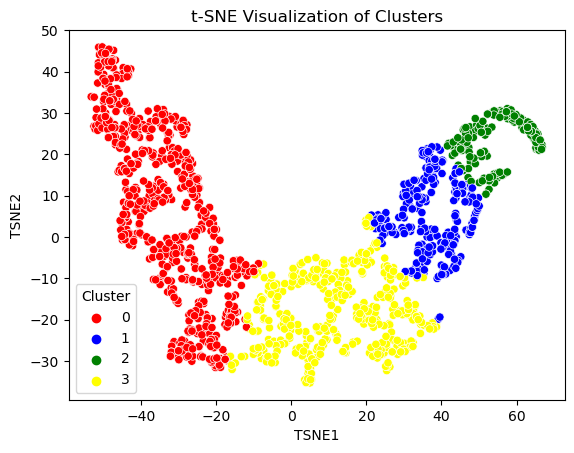

In [26]:
from sklearn.manifold import TSNE

def create_tsne_cluster_plot(data_frame, cluster):
    df = data_frame.drop([cluster], axis=1)

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=360, perplexity=30, n_iter=1000)

    # Fit t-SNE
    tsne_results = tsne.fit_transform(df)
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[cluster] = data_frame[cluster]

    return tsne_df


tsne_data = create_tsne_cluster_plot(data_frame=data, cluster="Cluster")
sns.scatterplot(x='TSNE1', y='TSNE2', hue="Cluster", data=tsne_data, palette=["red", "blue", "green", "yellow"])
plt.title('t-SNE Visualization of Clusters')
plt.show()

# Analyze each cluster

## Using Summary statistics

In [27]:
data["Cluster"].unique()

array([3, 1, 0, 2])

In [28]:
cluster_0 = data[data["Cluster"]==0]
cluster_1 = data[data["Cluster"]==1]
cluster_2 = data[data["Cluster"]==2]
cluster_3 = data[data["Cluster"]==3]

In [29]:
cluster_0.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_score,691.0,8.527931,1.750267,5.200000,7.10000,8.20000,9.80000,12.350000
device_rating,691.0,0.514428,0.185775,0.120000,0.37000,0.50000,0.64500,1.015000
data_quality,691.0,0.278929,0.210492,0.000000,0.07000,0.27000,0.46000,0.740000
ltv_rate,691.0,2.259407,0.607172,1.200000,1.80000,2.10000,2.50000,3.650000
bureau_score,691.0,0.079718,0.018094,0.040000,0.06700,0.07700,0.08900,0.120000
total_tenure,691.0,8.131693,3.878408,1.000000,5.00000,7.00000,10.00000,21.000000
months_active,691.0,20.091172,6.895835,6.000000,14.00000,20.00000,26.00000,35.000000
savings_score,691.0,0.996612,0.001767,0.992248,0.99546,0.99656,0.99773,1.001187
tx_score,691.0,3.301541,0.149040,2.925000,3.20000,3.29000,3.39000,3.685000
usage_score,691.0,0.647178,0.136202,0.330000,0.55000,0.63000,0.73000,1.000000


In [30]:
cluster_1.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_score,266.0,8.052820,1.472490,4.600000,7.20000,7.75000,8.9000,12.350000
device_rating,266.0,0.546711,0.174757,0.180000,0.41000,0.56000,0.6475,1.015000
data_quality,266.0,0.276485,0.176753,0.000000,0.14250,0.27000,0.3700,0.915000
ltv_rate,266.0,2.418421,0.612156,1.200000,2.00000,2.30000,2.6000,3.650000
bureau_score,266.0,0.082718,0.017986,0.040000,0.07400,0.08100,0.0920,0.120000
total_tenure,266.0,24.067669,9.235040,5.000000,16.00000,24.00000,31.0000,42.000000
months_active,266.0,74.597744,10.207186,58.000000,65.00000,73.00000,85.0000,93.000000
savings_score,266.0,0.996952,0.001821,0.992248,0.99606,0.99694,0.9979,1.001187
tx_score,266.0,3.323308,0.156855,2.925000,3.20000,3.31000,3.4300,3.685000
usage_score,266.0,0.646391,0.129989,0.400000,0.55250,0.62000,0.7200,1.000000


In [31]:
cluster_2.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_score,160.0,7.940313,1.227214,4.700000,7.20000,7.90000,8.65000,12.350000
device_rating,160.0,0.554469,0.154871,0.180000,0.46750,0.57000,0.63250,1.015000
data_quality,160.0,0.294937,0.146567,0.020000,0.21000,0.28000,0.37000,0.700000
ltv_rate,160.0,2.561250,0.708128,0.900000,2.00000,2.35000,3.05000,3.650000
bureau_score,160.0,0.085162,0.018994,0.040000,0.07475,0.08300,0.09625,0.120000
total_tenure,160.0,26.315625,9.215045,6.000000,19.00000,25.00000,34.00000,42.000000
months_active,160.0,111.518750,10.214044,94.000000,102.00000,112.50000,122.00000,122.000000
savings_score,160.0,0.996950,0.001911,0.992248,0.99620,0.99713,0.99800,1.001187
tx_score,160.0,3.257219,0.138287,2.925000,3.18000,3.26000,3.32000,3.685000
usage_score,160.0,0.634563,0.159590,0.390000,0.53000,0.58000,0.70000,1.000000


In [32]:
cluster_3.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_score,482.0,8.198859,1.691391,4.900000,7.000000,7.80000,9.0000,12.350000
device_rating,482.0,0.523133,0.160209,0.160000,0.400000,0.52000,0.6200,1.015000
data_quality,482.0,0.248402,0.192735,0.000000,0.080000,0.23000,0.3900,0.760000
ltv_rate,482.0,2.280290,0.549130,1.200000,1.900000,2.20000,2.6000,3.650000
bureau_score,482.0,0.081154,0.016688,0.040000,0.071000,0.07900,0.0890,0.120000
total_tenure,482.0,18.372407,7.696072,1.000000,13.000000,17.00000,23.0000,42.000000
months_active,482.0,44.665975,7.674135,31.000000,38.000000,44.00000,50.0000,62.000000
savings_score,482.0,0.996746,0.001806,0.992248,0.995505,0.99671,0.9978,1.001187
tx_score,482.0,3.333475,0.145540,2.925000,3.240000,3.35000,3.4200,3.685000
usage_score,482.0,0.660602,0.133727,0.430000,0.570000,0.63000,0.7400,1.000000


**Cluster 0:**
- Device Rating: Has the lowest average device rating among all clusters at approximately 0.514.
- Months Active: Relatively less active with an average of about 20.09 months, suggesting newer customers or shorter engagement durations.
- Data Quality: Lowest data quality average of all clusters at 0.279.

**Cluster 1:**
- Months Active: Significantly higher average months active at 74.6, suggesting well-established relationships with customers.
- Total Tenure: Highest average tenure at about 24.07 months, indicating long-term commitments.
- Data Quality: More consistent data quality with a lower variance compared to other clusters.

**Cluster 2:**
- Months Active: Highest average months active at 111.2, indicating the longest customer relationships or engagements.
- Total Tenure: Similar to Cluster 1 in showing long tenures but with the highest maximum tenure at 42 months.
- Device Rating: Lowest average device satisfaction despite longer customer engagement.

**Cluster 3:**
- Loan Score: Highest average loan score at approximately 8.19, indicating possibly higher creditworthiness or different loan handling.
- Airtime Score: Most variability in airtime scores, suggesting diverse usage patterns.
- Months Active: Lowest average months active at 44.6, which might indicate a mix of newer customer engagements compared to other clusters.

**Summary**
Each cluster's unique features suggest different customer profiles and behaviors, ranging from engagement duration to satisfaction ratings and financial behaviors, which can be crucial for targeted marketing, customer retention strategies, and personalized services.







## POTENTIAL BIAS IN KMEANS

**Shape and Size of Clusters:**
- K-Means assumes clusters are spherical and similar in size, which can bias it against recognizing clusters that are elongated or have varying densities and sizes. 

**Initial Centroid Selection:**
- The algorithm's sensitivity to initial centroid placement can lead to different results on each run unless advanced initialization techniques like K-Means are used. Random initial placements can result in poor convergence and sub-optimal clustering.

**Fixed Number of Clusters:**
- K-Means requires the number of clusters (K) to be specified a priori, which can be challenging without prior knowledge of the dataset’s structure. An incorrect choice of K can merge distinct groups or split coherent groups, leading to misleading clustering.

**Outlier Sensitivity:**
- The presence of outliers can skew the centroids significantly, resulting in distorted clusters. K-Means does not handle outliers well, as it tends to pull centroids toward them.

**Convergence to Local Minima:**
- K-Means can converge to local optima rather than the global optimum. This is dependent on the initial centroid positions and can lead to variations in clustering results across different runs.

Advantages of using K-means

**Simplicity and Speed:**
- K-Means is easy to understand and implement. The algorithm's simplicity leads to fast convergence, making it highly efficient for large datasets.

**Scalability:**
- It can handle large data sets efficiently, especially with optimizations such as K-Means++ for centroid initialization, which helps in reducing computation time.

**Adaptability with Large Features:**
- K-Means performs well with datasets having a large number of features, although preprocessing steps like normalization might be necessary to ensure all features contribute equally to the distance calculations.

**Efficient in High Dimensional Space:**
- Although clustering in very high-dimensional spaces can be challenging due to the curse of dimensionality, K-Means can still perform adequately when the number of dimensions isn’t excessively high.

**Comment on Feature Engineering and Clustering**
- 4 to 6 clusters might not be the optimal choice of cluster for this dataset

- If additional context about the dataset becomes available, it could greatly enhance our clustering efforts. Advanced feature engineering techniques can be leveraged to derive new features that capture more nuanced aspects of the data. These refined features would likely aid in the generation of more distinct and meaningful clusters by improving the representativeness and separation ability of the dataset within the feature space. This approach not only promises better clustering performance but also deeper insights into the underlying patterns and relationships.